# ¿Qué tan buenos somos para reconocer personas?

<img src="https://i.imgur.com/ECpBSfn.jpg" width="50%" />

<center>¿Jack Nicholson o Leonardo Dicaprio?</center>

<img src="http://1.bp.blogspot.com/_BQ05SdY_Qk0/SmoUY1TVaeI/AAAAAAAAAUE/NwiqQgpb_Dg/s400/Fabio+Posca+-+Bob+Pati%C3%B1o.jpg" width="50%" />

<div>

<img src="https://i.imgur.com/0ppqBFz.jpg" width="25%" />
<img src="https://lh6.googleusercontent.com/-60b0uUWJlhA/AAAAAAAAAAI/AAAAAAAAt4E/BHc54O2XIqs/photo.jpg" width="25%" />

</div>

<center>¿Fisa o guerrero medieval?</center>

Como queda claro, a veces la cosa se puede complicar y no resulta tan sencillo :). 

Para poder hacer esto, tenemos un conjunto de datos de datos que consiste en algunas miles de imágenes clasificadas de ariel, fisa, gabi y mariano. En cada uno de estos casos tenemos la certeza (etiqueta) de quién es quién en cada uno. Este set de datos lo vamos a usar para entrenar el modelo y ver qué tan bien le está yendo a la hora de clasificar esas personas.

# Dependencias

Vamos a estar usando varias libs útiles, que se instalan con pip:

    pip install pillow scikit-learn pandas matplotlib keras tensorflow h5py sh

# Generar imágenes a partir de videos (opcional)

Para este caso en particular, extrajimos imágenes de un grupo de videos usando el programa `ffmpeg`. En linux, puede instalarse con:

    sudo apt install ffmpeg 
    
Y luego se pueden generar imágenes a partir de un video, usándolo de esta forma:

    ffmpeg -i PATH_VIDEO -r FPS/1 PATH_IMAGENES/PREFIJO_%03d.jpg
    
Esto requiere especificar el path al video, los FPS que queremos sacar (cuántas imágenes por segundo de video), y el path y formato de los nombres de los archivos a generar. Por ejemplo, si tenemos un video "ariel.mp4", y queremos generar imágenes a 5 fps en un directorio "fotos_ariel", podríamos correrlo así:

    ffmpeg -i ariel.mp4 -r 5/1 fotos_ariel/foto_%03d.jpg


# Imports y configs

In [1]:
# de python, para especificar rutas de archivos y directorios
from pathlib import Path

# lib para trabajar con arrays
import numpy as np

# lib que usamos para mostrar las imágenes
import matplotlib.pyplot as plt

# libs que usamos para construir y entrenar redes neuronales, y que además tiene utilidades para leer sets de 
# imágenes
from keras.preprocessing import image_dataset_from_directory
from keras.models import Sequential
from keras.layers import Dense, Input, Dropout, Convolution2D, MaxPooling2D, Flatten
from keras.layers.experimental.preprocessing import Rescaling
from keras.preprocessing.image import load_img, img_to_array

# libs que usamos para tareas generales de machine learning. En este caso, métricas
from sklearn.metrics import accuracy_score, confusion_matrix

# configuración para que las imágenes se vean dentro del notebook
%matplotlib inline

Datos
=====

Para que esto funcione, deben bajar y descomprimir los dos sets de imágenes desde [este link](https://drive.google.com/drive/folders/0B5cCDhynqkqDczZDd3JTSENFcDg?usp=sharing).

Cada set tiene 3 directorios de imágenes, uno por cada profe. Vamos a utilizar las imágenes con cortina de fondo como set de validación, y el resto como set de entrenamiento.

In [2]:
# lo vamos a estar usando seguido
PROFES = "ariel", "mariano", "fisa"
# configurar de acuerdo a dónde bajaron los sets de imágenes
TRAIN_DIR = Path('./imagenes/train')
VALIDATION_DIR = Path('./imagenes/validation')

Lo primero que vamos a hacer es crear datasets de imágenes para Keras, usando sus propias herramientas:

In [3]:
train = image_dataset_from_directory(
    TRAIN_DIR,
    labels="inferred",  # adivinar los labels en base al nombre del sub directorio ("ariel", etc)
    label_mode="categorical",  # tenemos N labels, queremos tuplas de 0s y 1s indicando cuál de los labels es
    class_names=PROFES,  # para usar el mismo orden en todos lados
    color_mode="rgb",  # queremos trabajar con las imágenes a color
    image_size=(64, 64),  # para que corra más rápido, vamos a achicar las imágenes
    shuffle=True,  # que recorra el set de imágenes en orden aleatorio
    seed=42,  # semilla para que la aleatoriedad sea repetible
)

Found 2793 files belonging to 3 classes.


In [4]:
validation = image_dataset_from_directory(
    VALIDATION_DIR,
    labels="inferred",
    label_mode="categorical",
    class_names=PROFES,
    color_mode="rgb",
    image_size=(64, 64),
    shuffle=True,
    seed=42,
)

Found 869 files belonging to 3 classes.


Y con un poco de uso de Matplotlib, podemos mostrar ejemplos al azar de esas imágenes:

In [5]:
def sample_images(dataset):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(PROFES[np.argmax(labels[i])])
            plt.axis("off")

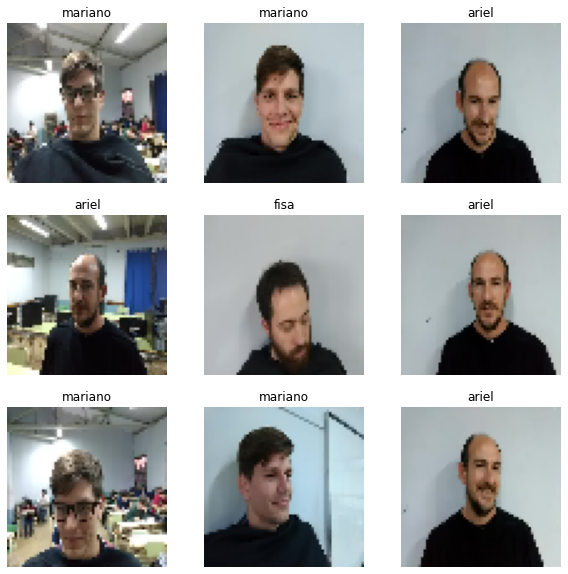

In [6]:
sample_images(train)

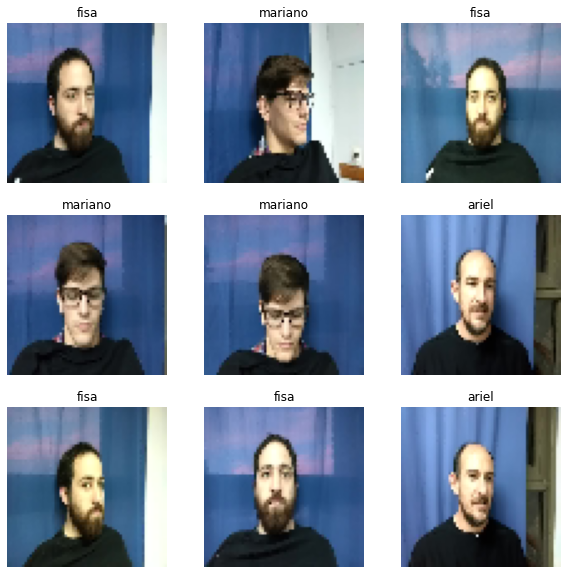

In [7]:
sample_images(validation)

Red neuronal
============

Y aquí es donde creamos y entrenamos el modelo. Vamos a usar redes convolucionales, porque se lleva naturalmente bien con el dataset que Keras nos sabe generar:

In [9]:
model = Sequential([
    # el shape de los inputs es alto_imagen * ancho_imagen * cantidad_colores
    # usamos una capa de Rescaling para normalizar las entradas de los datasets
    Rescaling(1/255, input_shape=(64, 64, 3)),

    Convolution2D(filters=8, kernel_size=(4, 4), strides=1, activation='relu'),
    Dropout(0.2),
    Convolution2D(filters=8, kernel_size=(4, 4), strides=1, activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(4, 4)),
    Flatten(),
    
    Dense(10, activation='tanh'),
    Dropout(0.2),
    Dense(10, activation='tanh'),
    Dropout(0.2),

    Dense(len(PROFES), activation='softmax'),
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy',],
)

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 61, 61, 8)         392       
_________________________________________________________________
dropout (Dropout)            (None, 61, 61, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 58, 58, 8)         1032      
_________________________________________________________________
dropout_1 (Dropout)          (None, 58, 58, 8)         0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 8)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1568)              0

In [10]:
history = model.fit(
    train,
    epochs=4,
    batch_size=128,
    validation_data=validation,
)

Epoch 1/4
88/88 [==============================] - 22s 230ms/step - loss: 0.8424 - accuracy: 0.6187 - val_loss: 0.5916 - val_accuracy: 0.7687
Epoch 2/4
88/88 [==============================] - 18s 196ms/step - loss: 0.2291 - accuracy: 0.9592 - val_loss: 0.4679 - val_accuracy: 0.7940
Epoch 3/4
88/88 [==============================] - 18s 204ms/step - loss: 0.0990 - accuracy: 0.9953 - val_loss: 0.7255 - val_accuracy: 0.7123
Epoch 4/4
88/88 [==============================] - 19s 207ms/step - loss: 0.0548 - accuracy: 0.9997 - val_loss: 0.4679 - val_accuracy: 0.7779


Graficamos accuracy de ambos conjuntos durante todo el proceso

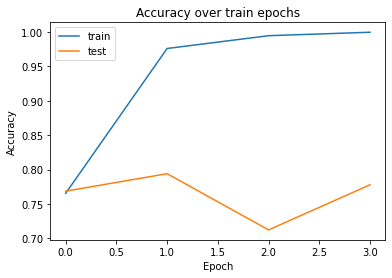

In [11]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.title('Accuracy over train epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

Y analizamos un poco el error en ambos conjuntos, prediciendo y calculando métricas y matrices de confusión/

######################### train #########################
accuracy 1.0


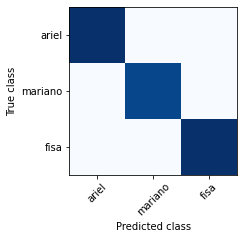

######################### validation #########################
accuracy 0.7779056386651323


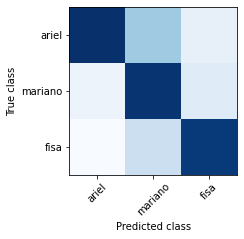

In [12]:
datasets = (
    ("train", train),
    ("validation", validation),   
)

for dataset_name, dataset in datasets:
    print('#' * 25, dataset_name, '#' * 25)

    # el dataset se itera en batches, así que calculams predicciones y labels por cada batch, y luego 
    # concatenamos todo
    batches_predictions = []
    batches_labels =  []
    
    for batch_images, batch_labels in dataset:
        # super importante: usamos argmax para convertir cosas de este formato:
        # [(0, 1, 0), (1, 0, 0), (1, 0, 0), (0, 0, 1)]
        # a este formato (donde tenemos el índice de la clase que tiene número más alto):
        # [1, 0, 0, 2]
        batches_predictions.append(np.argmax(model.predict(batch_images), axis=-1))
        batches_labels.append(np.argmax(batch_labels, axis=-1))

    predictions = np.concatenate(batches_predictions)
    labels = np.concatenate(batches_labels)
    
    print('accuracy', accuracy_score(labels, predictions))

    # graficamos la confussion matrix
    plt.figure(figsize=(3, 4))
        
    plt.xticks([0, 1, 2], PROFES, rotation=45)
    plt.yticks([0, 1, 2], PROFES)
    plt.xlabel('Predicted class')
    plt.ylabel('True class')

    plt.imshow(
        confusion_matrix(labels, predictions), 
        cmap=plt.cm.Blues,
        interpolation='nearest',
    )

    plt.show()

# Y ahora con imágenes nuevas, podemos usar nuestro predictor!

In [13]:
from IPython.display import Image, display


def show_and_predict(image_path):
    image_array = img_to_array(load_img(image_path, target_size=(64, 64)))
    inputs = np.array([image_array])  # armamos un "dataset" con solo esa imagen
    predictions = model.predict(inputs)
    display(Image(image_path, width=500))
    print("Prediction:", PROFES[np.argmax(predictions)])

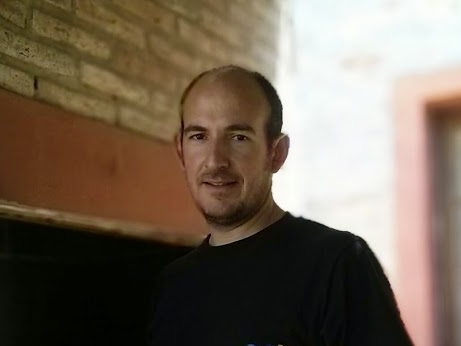

Prediction: ariel


In [14]:
show_and_predict("./ariel_asado.jpg")

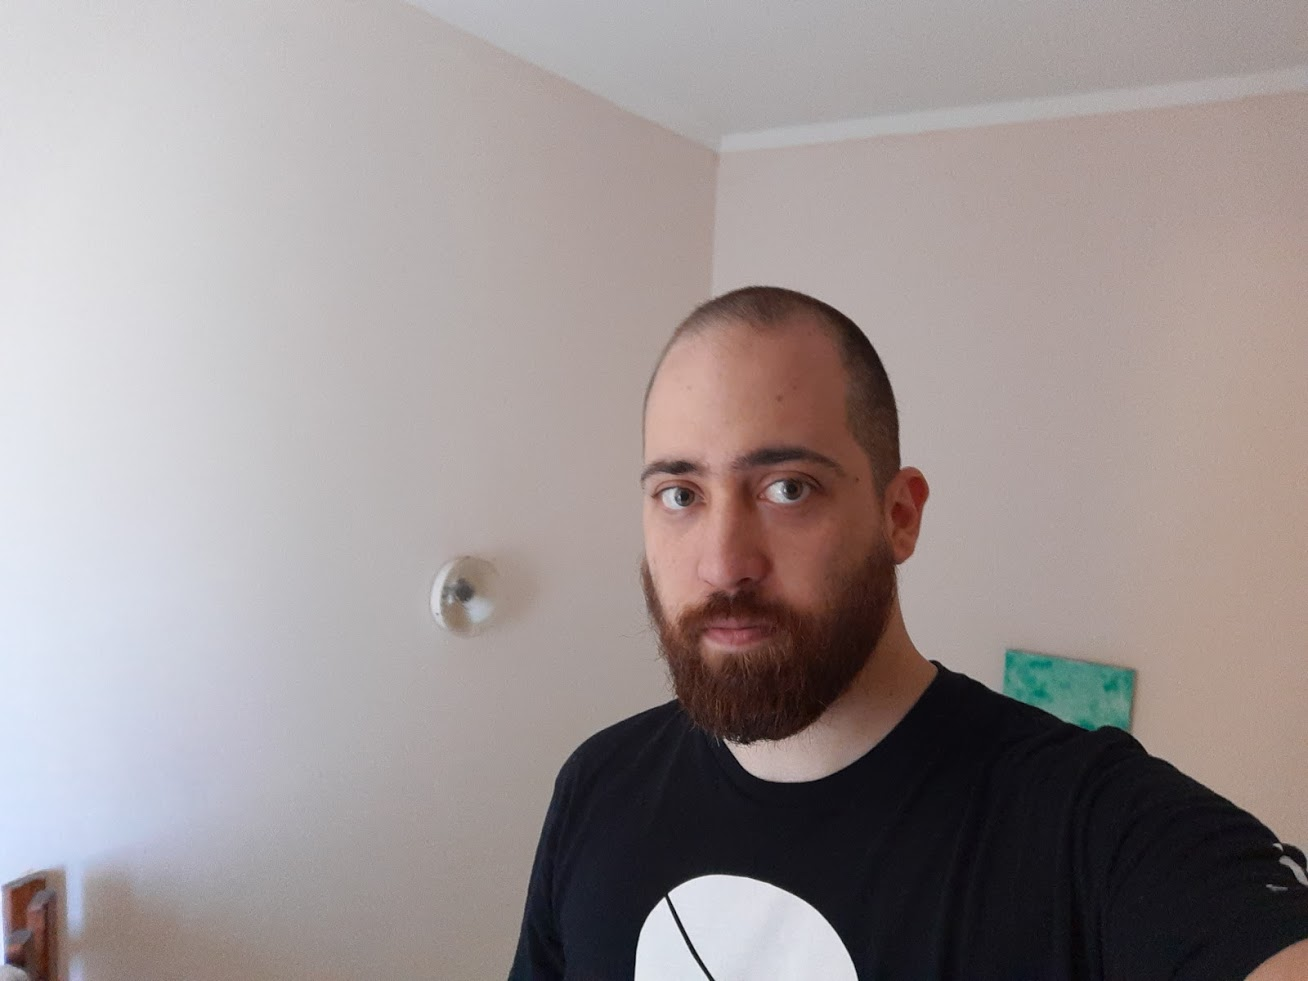

Prediction: fisa


In [15]:
show_and_predict("./fisa_pelado.jpg")